In [1]:
import keras
from keras import models, layers
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
from scipy.ndimage import imread
from scipy.misc import imresize
from nbutil import imshow_multi

Using TensorFlow backend.


In [24]:
dir = '/Users/nateparrott/Documents/School/cv/proj4/data'

categories = [c for c in os.listdir(os.path.join(dir, 'train')) if c[0] != '.']

SIZE = 32

def load_dataset(name):
    images = []
    labels = []
    for cat in categories:
        for filename in os.listdir(os.path.join(dir, name, cat)):
            if filename.endswith('.jpg'): 
                path = os.path.join(dir, name, cat, filename)
                image = imresize(imread(path), size=[SIZE, SIZE], mode='L')
                images.append(image)
                labels.append(categories.index(cat))
    images = np.expand_dims(np.stack(images) / 255.0, -1)
    labels = np.expand_dims(np.stack(labels).astype(int), -1)
    return images, labels

trainx, trainy = load_dataset('train')
testx, testy = load_dataset('test')


15


In [18]:
image_gen = ImageDataGenerator(rotation_range=10, 
                               zoom_range=0.2, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               horizontal_flip=True,
                               channel_shift_range=0.1)


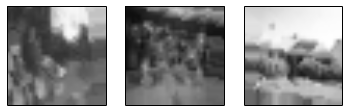

15


In [30]:
%matplotlib inline
for images, _ in image_gen.flow(trainx, trainy, batch_size=3):
    imshow_multi(images[:,:,:,0])
    break
print len(categories)


In [31]:
model = models.Sequential()
prev_channels = 1
for i, channels in enumerate([32, 64, 64, 64, 128]):
    in_size = [SIZE / (2 ** i), SIZE / (2 ** i), prev_channels]
    model.add(layers.Conv2D(channels, input_shape=in_size, activation='relu', padding='same', kernel_size=(3,3)))
    prev_channels = channels
    model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(len(categories), activation='softmax'))
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
dropout_17 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_18 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 64)          0         
__________

In [32]:
batch_size = 32

model.fit_generator(image_gen.flow(trainx, trainy, batch_size=batch_size),
                   steps_per_epoch=len(trainx)/batch_size,
                   verbose=2,
                   epochs=40,
                   validation_data=(testx, testy))

Epoch 1/40
17s - loss: 2.8814 - acc: 0.1630 - val_loss: 2.7025 - val_acc: 0.0834
Epoch 2/40
13s - loss: 2.3999 - acc: 0.2526 - val_loss: 2.7394 - val_acc: 0.0764
Epoch 3/40
13s - loss: 2.2078 - acc: 0.3086 - val_loss: 2.9290 - val_acc: 0.0764
Epoch 4/40
14s - loss: 2.1677 - acc: 0.3121 - val_loss: 2.9002 - val_acc: 0.0764
Epoch 5/40
14s - loss: 1.9988 - acc: 0.3635 - val_loss: 2.8922 - val_acc: 0.0764
Epoch 6/40
15s - loss: 1.9914 - acc: 0.3588 - val_loss: 2.9467 - val_acc: 0.0764
Epoch 7/40
15s - loss: 1.8237 - acc: 0.3933 - val_loss: 3.0332 - val_acc: 0.0767
Epoch 8/40
15s - loss: 1.8392 - acc: 0.3894 - val_loss: 2.9226 - val_acc: 0.0868
Epoch 9/40
14s - loss: 1.7795 - acc: 0.4137 - val_loss: 2.9454 - val_acc: 0.1648
Epoch 10/40
14s - loss: 1.7093 - acc: 0.4381 - val_loss: 3.0145 - val_acc: 0.1039
Epoch 11/40
14s - loss: 1.6893 - acc: 0.4423 - val_loss: 2.8286 - val_acc: 0.1631
Epoch 12/40
14s - loss: 1.5826 - acc: 0.4689 - val_loss: 2.9912 - val_acc: 0.1136
Epoch 13/40
16s - loss: 1

In [7]:
score = model.evaluate(testx, testy, verbose=0)
print 'accuracy: {}'.format(score[1])

accuracy: 0.402345058636
